In [1]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import random

# Use seaborn style for better visuals
sns.set_style("whitegrid")

In [2]:
# Define Paths
# Try to determine root
import os

if os.path.exists("data/olive_diseases"):
    WORKSPACE_ROOT = "."
elif os.path.exists("../data/olive_diseases"):
    WORKSPACE_ROOT = ".."
else:
    print("Warning: Could not find data directory. Please set WORKSPACE_ROOT manually.")
    WORKSPACE_ROOT = "." # Default fallback

DATA_ROOT = os.path.join(WORKSPACE_ROOT, "data/olive_diseases")
ANNOTATIONS_DIR = os.path.join(DATA_ROOT, "annotations")
# We will use all_images for looking up files since we are combining splits
TRAIN_IMAGES_DIR = os.path.join(DATA_ROOT, "all_images")

# Define all splits to combine
SPLITS = ["train2017", "val2017", "test2017"]
ANNOTATION_FILES = {split: os.path.join(ANNOTATIONS_DIR, f"instances_{split}.json") for split in SPLITS}

print(f"Data Root: {DATA_ROOT}")
print(f"Images Dir: {TRAIN_IMAGES_DIR}")

for split, path in ANNOTATION_FILES.items():
    found = "Found" if os.path.exists(path) else "MISSING"
    print(f"{split}: {path} [{found}]")

Data Root: ../data/olive_diseases
Images Dir: ../data/olive_diseases/all_images
train2017: ../data/olive_diseases/annotations/instances_train2017.json [Found]
val2017: ../data/olive_diseases/annotations/instances_val2017.json [Found]
test2017: ../data/olive_diseases/annotations/instances_test2017.json [Found]


In [3]:
# Load and Merge Annotations from all splits
combined_coco = {
    "images": [],
    "annotations": [],
    "categories": []
}

# Counters for re-indexing to ensure unique IDs across splits
img_id_offset = 0
ann_id_offset = 0

for split, path in ANNOTATION_FILES.items():
    if not os.path.exists(path):
        continue
        
    print(f"Loading {split}...")
    with open(path, 'r') as f:
        data = json.load(f)
    
    # Categories (assume identical across splits, take from first)
    if not combined_coco["categories"]:
        combined_coco["categories"] = data["categories"]
    
    # Map old image IDs to new unique IDs
    img_id_map = {}
    current_max_img_id = 0
    current_max_ann_id = 0
    
    for img in data["images"]:
        original_id = img['id']
        new_id = original_id + img_id_offset
        img_id_map[original_id] = new_id
        
        new_img = img.copy()
        new_img['id'] = new_id
        combined_coco['images'].append(new_img)
        if original_id > current_max_img_id:
            current_max_img_id = original_id

    for ann in data["annotations"]:
        new_ann = ann.copy()
        new_ann['id'] = ann['id'] + ann_id_offset
        if ann['image_id'] in img_id_map:
             new_ann['image_id'] = img_id_map[ann['image_id']]
        else:
             # Skip annotations for images we didn't add (unlikely if valid COCO)
             continue
             
        combined_coco['annotations'].append(new_ann)
        if ann['id'] > current_max_ann_id:
            current_max_ann_id = ann['id']

    # Update offsets for next split
    # Add a buffer or just use max + 1 to keep IDs distinct
    img_id_offset += (current_max_img_id + 1000)
    ann_id_offset += (current_max_ann_id + 1000)

coco_data = combined_coco
print("\nCombined Dataset Stats:")
print("Dataset Keys:", coco_data.keys())
print(f"Number of Images: {len(coco_data['images'])}")
print(f"Number of Annotations: {len(coco_data['annotations'])}")
print(f"Number of Categories: {len(coco_data['categories'])}")

Loading train2017...
Loading val2017...
Loading test2017...

Combined Dataset Stats:
Dataset Keys: dict_keys(['images', 'annotations', 'categories'])
Number of Images: 1369
Number of Annotations: 4839
Number of Categories: 5


Top Categories by instance count:
   category_id     category_name  count
1            5      Tuberculosis   1136
3            2        BlackScale   1062
0            3  OlivePeacockSpot   1025
2            1       Anthracnose    839
4            4           Psyllid    777


/var/folders/18/tt4qk8fx5kj_pq96nkcnfxzh0000gn/T/ipykernel_90706/341998487.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cats, x='count', y='category_name', palette='viridis')


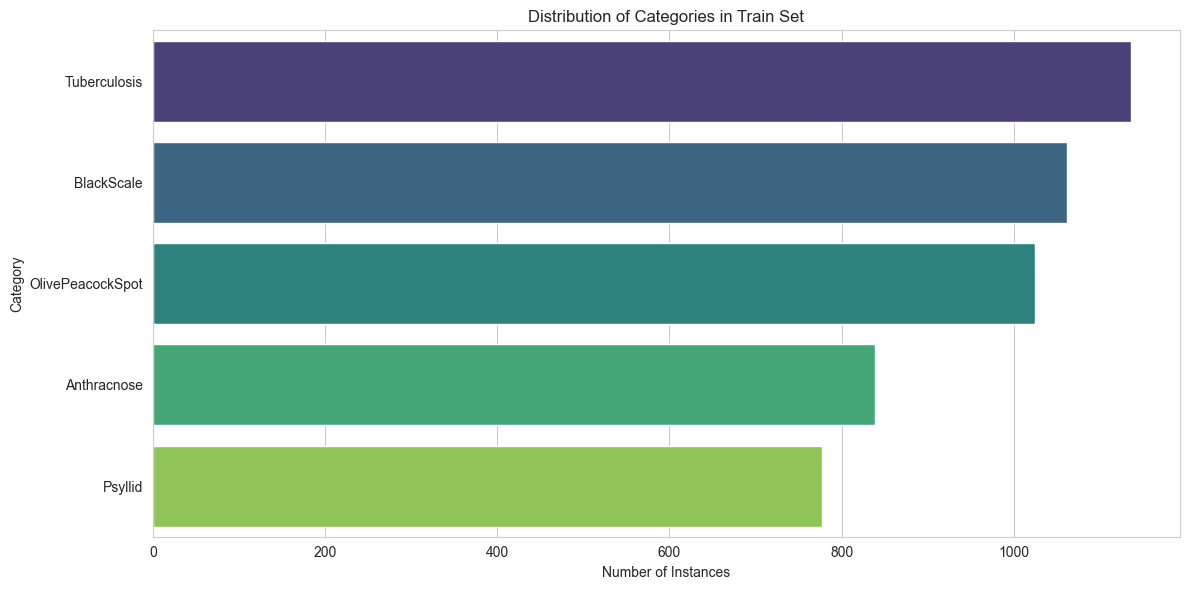

In [4]:
# Category Analysis
categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
cat_counts = collections.defaultdict(int)

for ann in coco_data['annotations']:
    cat_counts[ann['category_id']] += 1

# Create DataFrame
df_cats = pd.DataFrame([
    {'category_id': cid, 'category_name': categories[cid], 'count': count} 
    for cid, count in cat_counts.items()
]).sort_values('count', ascending=False)

print("Top Categories by instance count:")
print(df_cats.head(10))

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_cats, x='count', y='category_name', palette='viridis')
plt.title('Distribution of Categories in Train Set')
plt.xlabel('Number of Instances')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

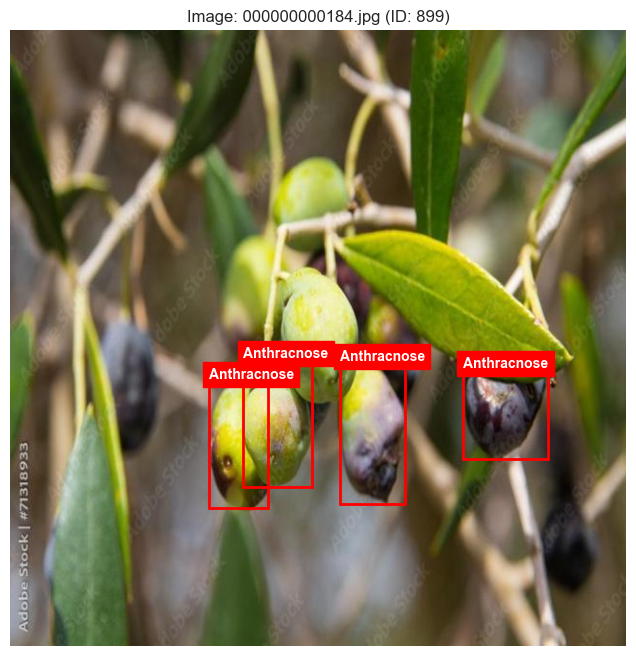

Could not find image: 000000001329.jpg


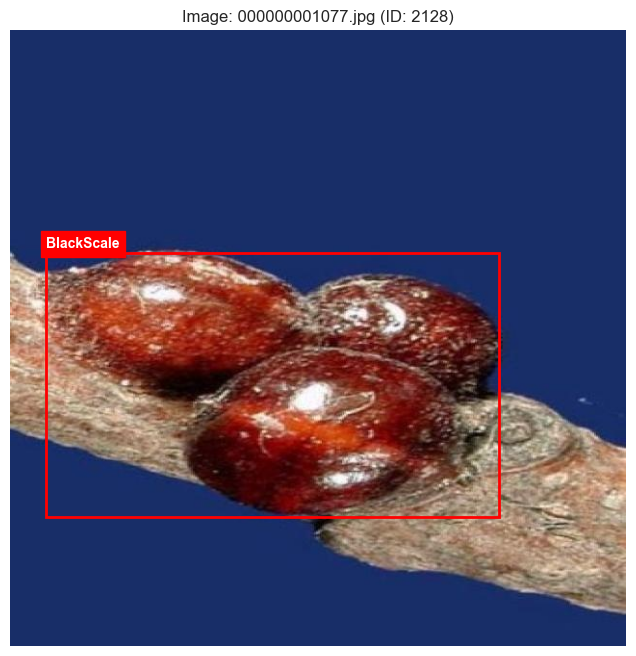

In [5]:
# Visualize Sample Images with Bounding Boxes

def show_sample_images(num_samples=3):
    # Select random images that have annotations
    annotated_image_ids = list(set([ann['image_id'] for ann in coco_data['annotations']]))
    sample_ids = random.sample(annotated_image_ids, num_samples)
    
    for img_id in sample_ids:
        img_info = next(img for img in coco_data['images'] if img['id'] == img_id)
        img_filename = img_info['file_name']
        img_path = os.path.join(TRAIN_IMAGES_DIR, img_filename)
        
        # Fallback if image not in train2017 (in case structure differs)
        if not os.path.exists(img_path):
            # Check all_images
            img_path = os.path.join(DATA_ROOT, "all_images", img_filename)
            
        if not os.path.exists(img_path):
            print(f"Could not find image: {img_filename}")
            continue

        try:
            image = Image.open(img_path)
            # Annotations for this image
            current_anns = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_id]
            
            plt.figure(figsize=(10, 8))
            plt.imshow(image)
            ax = plt.gca()
            
            for ann in current_anns:
                bbox = ann['bbox'] # [x, y, w, h]
                cat_name = categories[ann['category_id']]
                
                # Draw Box
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                
                # Add Label
                plt.text(bbox[0], bbox[1]-5, cat_name, color='white', backgroundcolor='red', fontsize=10, weight='bold')
                
            plt.title(f"Image: {img_filename} (ID: {img_id})")
            plt.axis('off')
            plt.show()
            
        except Exception as e:
            print(f"Error processing image {img_filename}: {e}")

show_sample_images(3)

In [ ]:
# Combine datasets from train, val, and test splits into a single dataset


